## Setup

Import libraries and load trajectory data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Configure paths
dataset_name = "bellevue_116th_ne12th"  # Change to your dataset
processed_dir = Path(f"../data/processed/{dataset_name}")

# Load trajectory data
trajs = pd.read_parquet(processed_dir / "trajectories.parquet")

print(f"Loaded {len(trajs)} trajectory points")
print(f"Number of unique tracks: {trajs['track_id'].nunique()}")
print(f"\nColumns: {trajs.columns.tolist()}")

Loaded 18841575 trajectory points
Number of unique tracks: 19827

Columns: ['track_id', 'frame', 'x', 'y', 'vx', 'vy', 'ax', 'ay']


## Basic Statistics

Understand the distribution of trajectory properties.

In [2]:
# Compute track-level statistics
track_stats = trajs.groupby('track_id').agg({
    'frame': ['count', 'min', 'max'],
    'x': ['min', 'max', 'mean', 'std'],
    'y': ['min', 'max', 'mean', 'std'],
    'vx': ['mean', 'std'],
    'vy': ['mean', 'std'],
    'ax': ['mean', 'std'],
    'ay': ['mean', 'std']
})

track_stats.columns = ['_'.join(col).strip() for col in track_stats.columns.values]
# Add duration column (which is frame_count)
track_stats['duration'] = track_stats['frame_count']

print("Track duration statistics:")
print(f"  Min: {track_stats['duration'].min()} frames")
print(f"  Max: {track_stats['duration'].max()} frames")
print(f"  Mean: {track_stats['duration'].mean():.1f} frames")
print(f"  Median: {track_stats['duration'].median():.1f} frames")

print("\nSpatial extent:")
print(f"  X range: [{trajs['x'].min():.3f}, {trajs['x'].max():.3f}]")
print(f"  Y range: [{trajs['y'].min():.3f}, {trajs['y'].max():.3f}]")

print("\nVelocity statistics:")
print(f"  |v| mean: {np.sqrt(trajs['vx']**2 + trajs['vy']**2).mean():.3f}")
print(f"  |v| max: {np.sqrt(trajs['vx']**2 + trajs['vy']**2).max():.3f}")

track_stats.head()

Track duration statistics:
  Min: 3 frames
  Max: 17094 frames
  Mean: 950.3 frames
  Median: 520.0 frames

Spatial extent:
  X range: [-0.428, 2.118]
  Y range: [-0.097, 1.183]

Velocity statistics:
  |v| mean: 0.233
  |v| max: 22.308


,frame_count,frame_min,frame_max,x_min,x_max,x_mean,x_std,y_min,y_max,y_mean,y_std,vx_mean,vx_std,vy_mean,vy_std,ax_mean,ax_std,ay_mean,ay_std,duration
track_id,,,,,,,,,,,,,,,,,,,,
1,7941,1,2485,0.143038,1.543600,0.565510,0.286894,0.317048,0.709608,0.551557,0.063597,0.002846,2.416565,-0.000893,0.677093,0.017139,50.993272,0.003873,14.428516,7941
2,17094,1,4596,0.022712,1.155544,0.459217,0.151338,0.192950,0.741931,0.575241,0.054597,0.001376,1.893376,-0.000862,0.660956,-0.015081,40.798846,0.003323,14.386502,17094
3,10361,1,2526,0.028331,1.477264,0.498011,0.222845,0.254801,0.797920,0.530531,0.074859,0.002033,2.521697,0.000268,1.130963,-0.003078,55.551925,-0.008890,24.764642,10361
4,9353,1,2177,-0.016799,1.427273,0.418519,0.181642,0.170268,0.798647,0.579035,0.073107,0.000122,2.248801,-0.001208,1.128280,0.009550,50.314615,-0.002687,25.302717,9353
5,9587,1,3473,0.200986,1.540251,0.581662,0.256222,0.221931,0.665380,0.510286,0.079771,0.001990,1.963628,-0.000549,0.695937,-0.020142,43.465110,-0.000161,15.540851,9587


## Duration Analysis

Identify very short tracks (likely noise) and very long tracks (potential tracking errors).

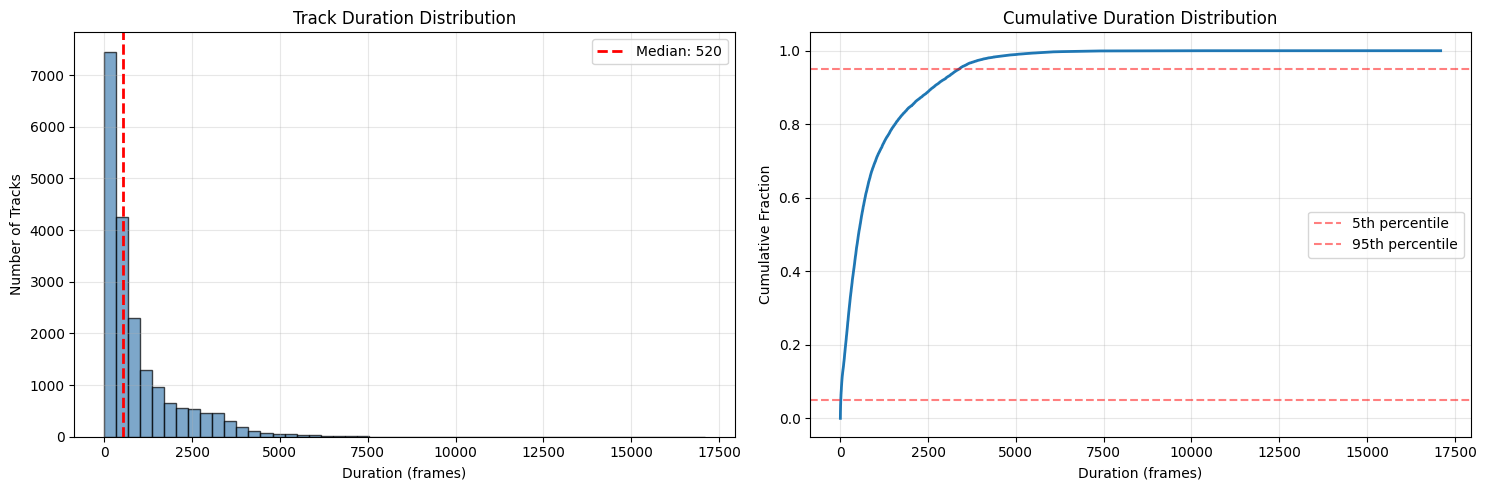


Duration percentiles:
  5th: 15 frames
  10th: 45 frames
  25th: 205 frames
  50th: 520 frames
  75th: 1242 frames
  90th: 2641 frames
  95th: 3381 frames


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of track durations
ax = axes[0]
ax.hist(track_stats['duration'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(track_stats['duration'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {track_stats["duration"].median():.0f}')
ax.set_xlabel('Duration (frames)')
ax.set_ylabel('Number of Tracks')
ax.set_title('Track Duration Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Cumulative distribution
ax = axes[1]
sorted_durations = np.sort(track_stats['duration'])
cumulative = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)
ax.plot(sorted_durations, cumulative, linewidth=2)
ax.axhline(0.05, color='red', linestyle='--', alpha=0.5, label='5th percentile')
ax.axhline(0.95, color='red', linestyle='--', alpha=0.5, label='95th percentile')
ax.set_xlabel('Duration (frames)')
ax.set_ylabel('Cumulative Fraction')
ax.set_title('Cumulative Duration Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Percentiles
print("\nDuration percentiles:")
for p in [5, 10, 25, 50, 75, 90, 95]:
    val = np.percentile(track_stats['duration'], p)
    print(f"  {p}th: {val:.0f} frames")

## Spatial Distribution

Visualize where tracks enter, exit, and travel.

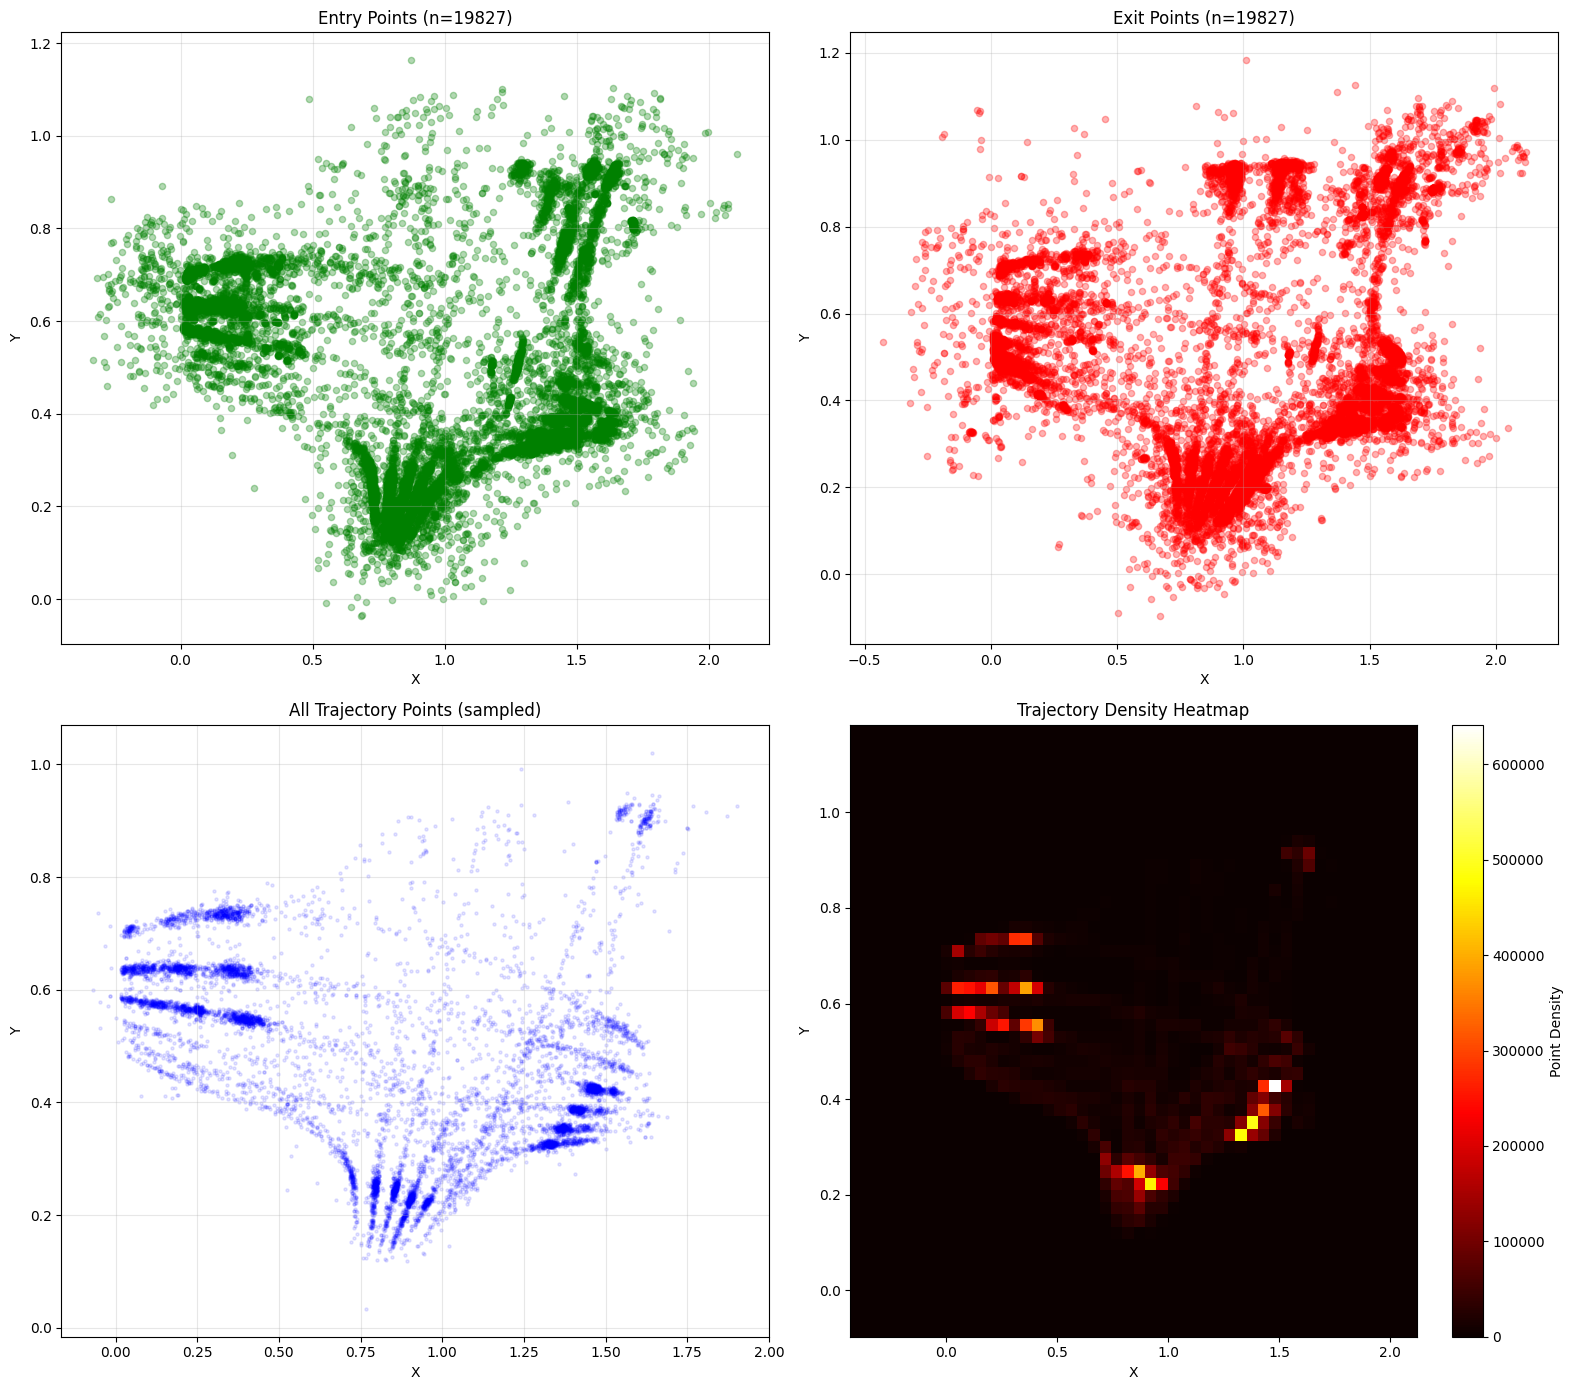

In [4]:
# Compute entry/exit points for each track
g = trajs.sort_values("frame").groupby("track_id")
entry_points = g.first()[["x", "y"]]
exit_points = g.last()[["x", "y"]]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Entry points
ax = axes[0, 0]
ax.scatter(entry_points['x'], entry_points['y'], alpha=0.3, s=20, c='green')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Entry Points (n={len(entry_points)})')
ax.grid(True, alpha=0.3)

# Exit points
ax = axes[0, 1]
ax.scatter(exit_points['x'], exit_points['y'], alpha=0.3, s=20, c='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Exit Points (n={len(exit_points)})')
ax.grid(True, alpha=0.3)

# All trajectory points (sample)
ax = axes[1, 0]
sample_trajs = trajs.sample(min(10000, len(trajs)))
ax.scatter(sample_trajs['x'], sample_trajs['y'], alpha=0.1, s=5, c='blue')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('All Trajectory Points (sampled)')
ax.grid(True, alpha=0.3)

# Heatmap of trajectory density
ax = axes[1, 1]
h = ax.hist2d(trajs['x'], trajs['y'], bins=50, cmap='hot')
plt.colorbar(h[3], ax=ax, label='Point Density')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectory Density Heatmap')

plt.tight_layout()
plt.show()

## Velocity and Acceleration Analysis

Detect unrealistic velocities (tracking errors, edge artifacts).

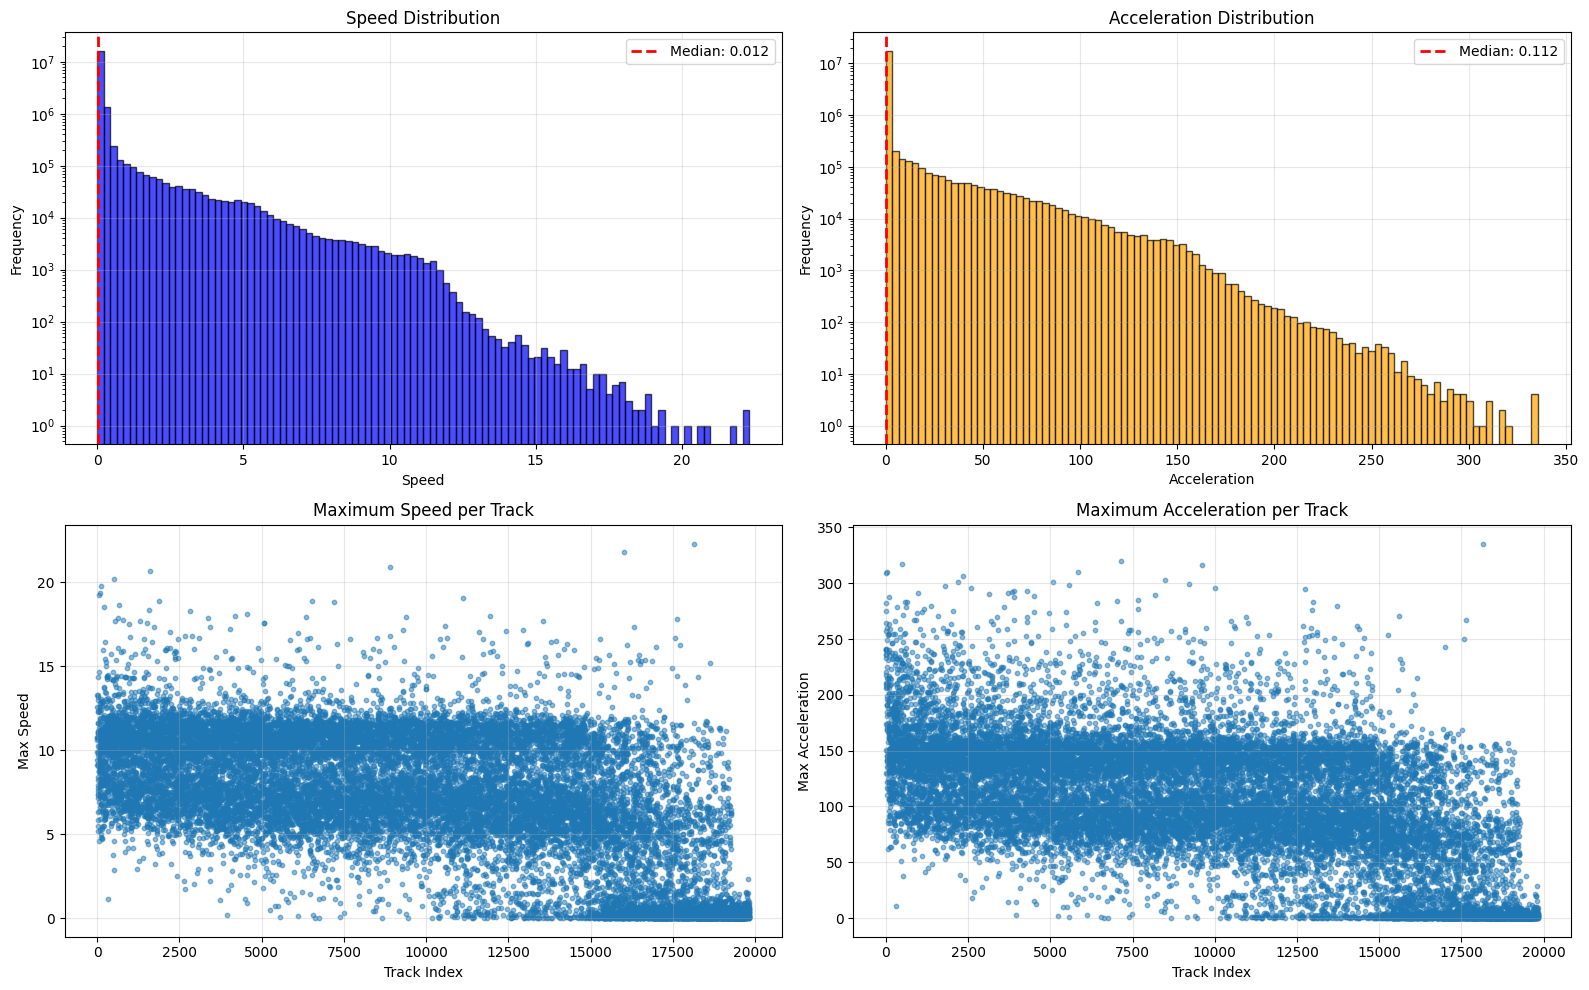


Speed statistics:
  Mean: 0.233
  Median: 0.012
  95th percentile: 1.010
  99th percentile: 4.813

Acceleration statistics:
  Mean: 3.464
  Median: 0.112
  Mean: 3.464
  Median: 0.112
  95th percentile: 20.605
  99th percentile: 81.662
  95th percentile: 20.605
  99th percentile: 81.662


In [5]:
# Compute speed and acceleration magnitude
trajs['speed'] = np.sqrt(trajs['vx']**2 + trajs['vy']**2)
trajs['accel'] = np.sqrt(trajs['ax']**2 + trajs['ay']**2)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Speed distribution
ax = axes[0, 0]
ax.hist(trajs['speed'], bins=100, color='blue', edgecolor='black', alpha=0.7)
ax.axvline(trajs['speed'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {trajs["speed"].median():.3f}')
ax.set_xlabel('Speed')
ax.set_ylabel('Frequency')
ax.set_title('Speed Distribution')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Acceleration distribution
ax = axes[0, 1]
ax.hist(trajs['accel'], bins=100, color='orange', edgecolor='black', alpha=0.7)
ax.axvline(trajs['accel'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {trajs["accel"].median():.3f}')
ax.set_xlabel('Acceleration')
ax.set_ylabel('Frequency')
ax.set_title('Acceleration Distribution')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Speed vs Track ID (detect outliers)
ax = axes[1, 0]
track_speed_max = trajs.groupby('track_id')['speed'].max()
ax.scatter(range(len(track_speed_max)), track_speed_max, alpha=0.5, s=10)
ax.set_xlabel('Track Index')
ax.set_ylabel('Max Speed')
ax.set_title('Maximum Speed per Track')
ax.grid(True, alpha=0.3)

# Acceleration vs Track ID
ax = axes[1, 1]
track_accel_max = trajs.groupby('track_id')['accel'].max()
ax.scatter(range(len(track_accel_max)), track_accel_max, alpha=0.5, s=10)
ax.set_xlabel('Track Index')
ax.set_ylabel('Max Acceleration')
ax.set_title('Maximum Acceleration per Track')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSpeed statistics:")
print(f"  Mean: {trajs['speed'].mean():.3f}")
print(f"  Median: {trajs['speed'].median():.3f}")
print(f"  95th percentile: {trajs['speed'].quantile(0.95):.3f}")
print(f"  99th percentile: {trajs['speed'].quantile(0.99):.3f}")

print("\nAcceleration statistics:")
print(f"  Mean: {trajs['accel'].mean():.3f}")
print(f"  Median: {trajs['accel'].median():.3f}")
print(f"  95th percentile: {trajs['accel'].quantile(0.95):.3f}")
print(f"  99th percentile: {trajs['accel'].quantile(0.99):.3f}")

## Identify Noise Tracks

Flag tracks that are likely noise based on multiple criteria.

In [6]:
# Define noise criteria
MIN_DURATION = 10  # frames (adjust based on FPS)
MAX_SPEED = trajs['speed'].quantile(0.99)  # Remove top 1% fastest
MAX_ACCEL = trajs['accel'].quantile(0.99)  # Remove top 1% acceleration

# Compute per-track metrics
track_metrics = trajs.groupby('track_id').agg({
    'frame': 'count',
    'speed': 'max',
    'accel': 'max',
    'x': ['min', 'max'],
    'y': ['min', 'max']
})

track_metrics.columns = ['_'.join(col).strip() for col in track_metrics.columns.values]
track_metrics['duration'] = track_metrics['frame_count']
track_metrics['x_range'] = track_metrics['x_max'] - track_metrics['x_min']
track_metrics['y_range'] = track_metrics['y_max'] - track_metrics['y_min']
track_metrics['travel_distance'] = np.sqrt(track_metrics['x_range']**2 + track_metrics['y_range']**2)

# Apply noise filters
track_metrics['is_too_short'] = track_metrics['duration'] < MIN_DURATION
track_metrics['is_too_fast'] = track_metrics['speed_max'] > MAX_SPEED
track_metrics['is_too_jerky'] = track_metrics['accel_max'] > MAX_ACCEL
track_metrics['is_stationary'] = track_metrics['travel_distance'] < 0.05  # Barely moved

# Combined noise flag
track_metrics['is_noise'] = (
    track_metrics['is_too_short'] |
    track_metrics['is_too_fast'] |
    track_metrics['is_too_jerky'] |
    track_metrics['is_stationary']
)

print("Noise Detection Results:")
print(f"  Total tracks: {len(track_metrics)}")
print(f"  Too short (<{MIN_DURATION} frames): {track_metrics['is_too_short'].sum()} ({100*track_metrics['is_too_short'].mean():.1f}%)")
print(f"  Too fast (>{MAX_SPEED:.2f}): {track_metrics['is_too_fast'].sum()} ({100*track_metrics['is_too_fast'].mean():.1f}%)")
print(f"  Too jerky (>{MAX_ACCEL:.2f}): {track_metrics['is_too_jerky'].sum()} ({100*track_metrics['is_too_jerky'].mean():.1f}%)")
print(f"  Stationary (<0.05): {track_metrics['is_stationary'].sum()} ({100*track_metrics['is_stationary'].mean():.1f}%)")
print(f"  Total flagged as noise: {track_metrics['is_noise'].sum()} ({100*track_metrics['is_noise'].mean():.1f}%)")

track_metrics.head(20)

Noise Detection Results:
  Total tracks: 19827
  Too short (<10 frames): 673 (3.4%)
  Too fast (>4.81): 15183 (76.6%)
  Too jerky (>81.66): 13139 (66.3%)
  Stationary (<0.05): 1510 (7.6%)
  Total flagged as noise: 16777 (84.6%)


,frame_count,speed_max,accel_max,x_min,x_max,y_min,y_max,duration,x_range,y_range,travel_distance,is_too_short,is_too_fast,is_too_jerky,is_stationary,is_noise
track_id,,,,,,,,,,,,,,,,
1,7941,10.755542,220.666328,0.143038,1.543600,0.317048,0.709608,7941,1.400562,0.392560,1.454537,False,True,True,False,True
2,17094,9.114894,206.154424,0.022712,1.155544,0.192950,0.741931,17094,1.132831,0.548981,1.258843,False,True,True,False,True
3,10361,10.734386,240.804262,0.028331,1.477264,0.254801,0.797920,10361,1.448933,0.543119,1.547380,False,True,True,False,True
4,9353,10.603809,256.853313,-0.016799,1.427273,0.170268,0.798647,9353,1.444072,0.628379,1.574866,False,True,True,False,True
5,9587,9.441815,208.973725,0.200986,1.540251,0.221931,0.665380,9587,1.339265,0.443449,1.410772,False,True,True,False,True
6,8906,12.589355,264.459515,-0.152128,1.613660,0.217904,0.833508,8906,1.765789,0.615604,1.870021,False,True,True,False,True
7,7867,13.314632,282.183616,-0.058667,1.684912,0.219718,0.810387,7867,1.743579,0.590669,1.840912,False,True,True,False,True
8,4974,9.895674,235.408460,0.111962,1.541776,0.163847,0.928217,4974,1.429814,0.764370,1.621305,False,True,True,False,True
9,9564,11.612235,236.274998,0.035378,1.524191,0.175637,0.774170,9564,1.488814,0.598533,1.604621,False,True,True,False,True


## Visualize Noise vs Clean Tracks

Compare spatial distribution of noise vs clean trajectories.

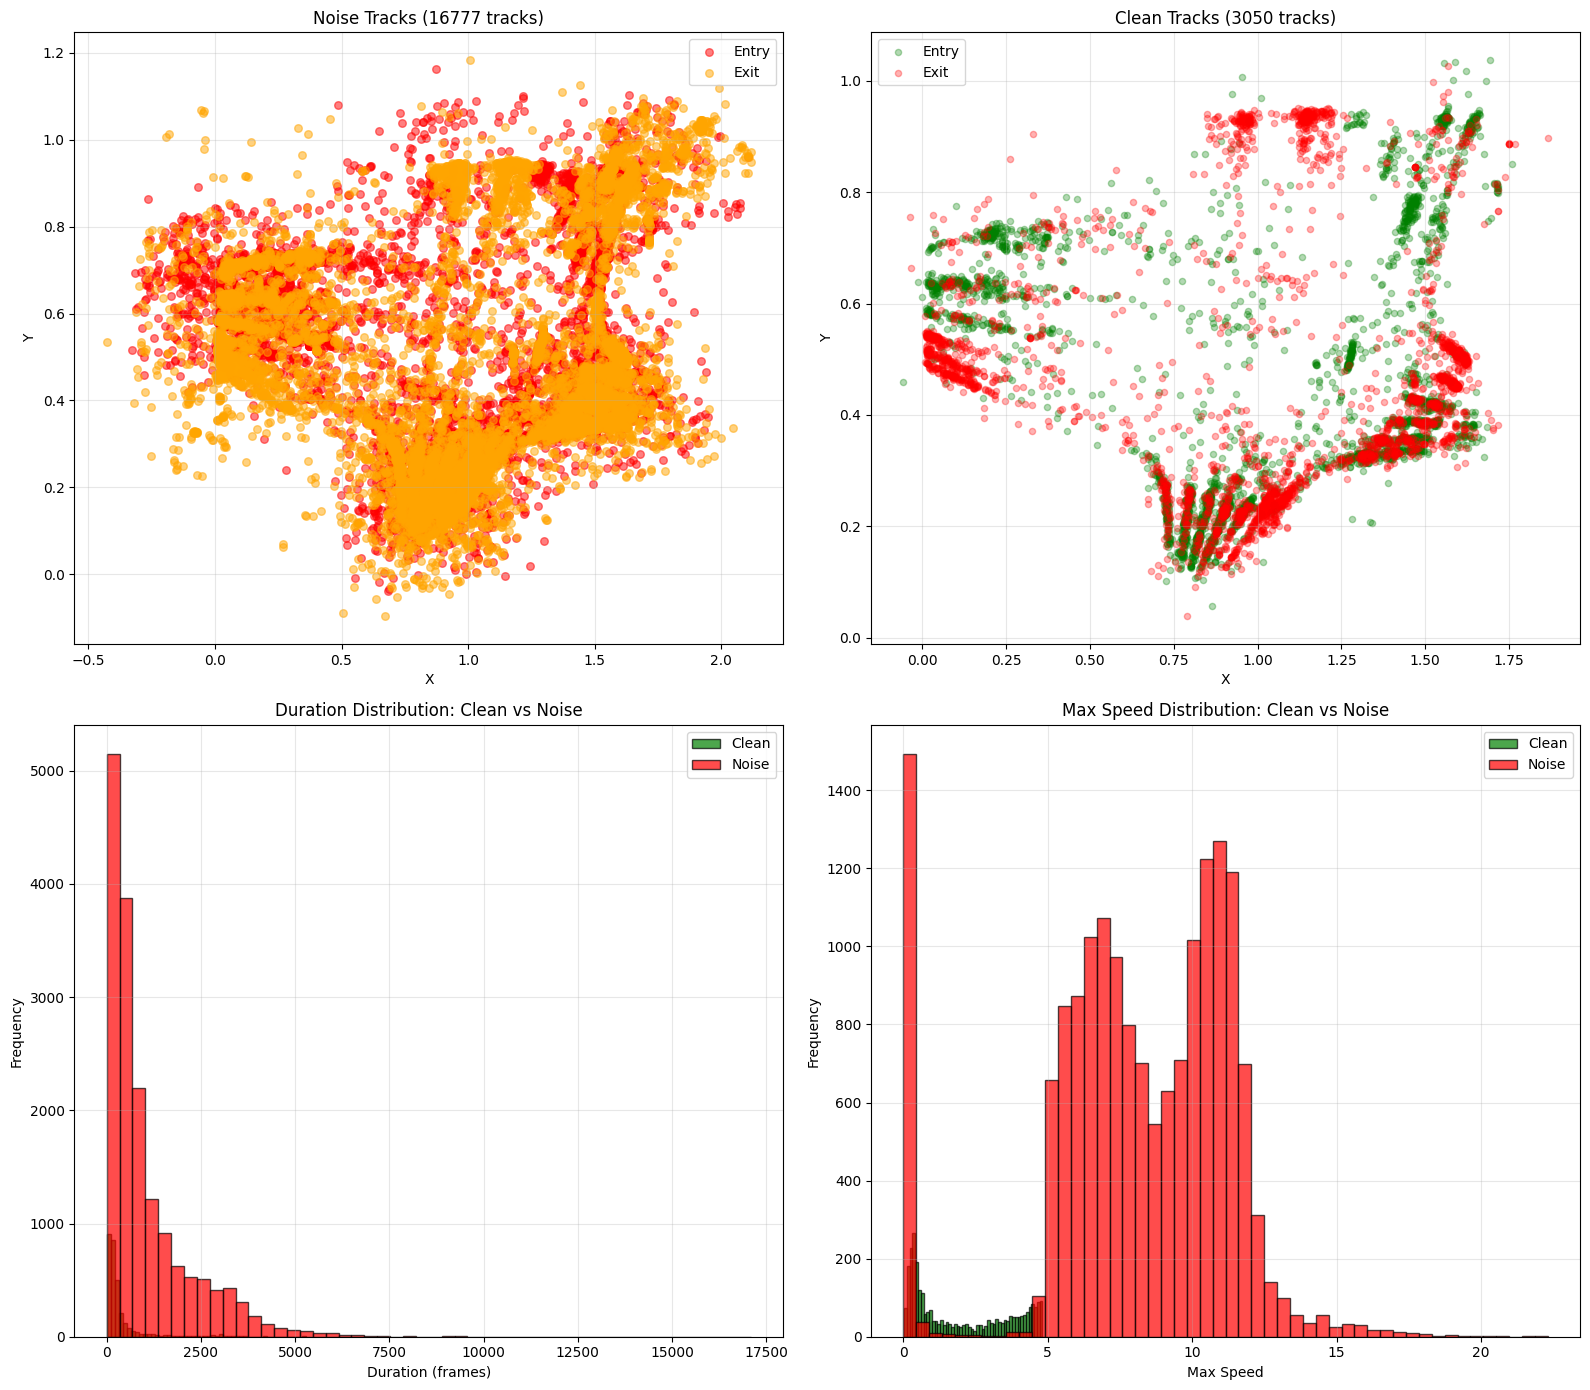

In [7]:
# Split tracks into noise and clean
noise_track_ids = track_metrics[track_metrics['is_noise']].index
clean_track_ids = track_metrics[~track_metrics['is_noise']].index

noise_trajs = trajs[trajs['track_id'].isin(noise_track_ids)]
clean_trajs = trajs[trajs['track_id'].isin(clean_track_ids)]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Noise entry/exit
ax = axes[0, 0]
noise_entry = noise_trajs.groupby('track_id').first()
noise_exit = noise_trajs.groupby('track_id').last()
ax.scatter(noise_entry['x'], noise_entry['y'], alpha=0.5, s=30, c='red', label='Entry')
ax.scatter(noise_exit['x'], noise_exit['y'], alpha=0.5, s=30, c='orange', label='Exit')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Noise Tracks ({len(noise_track_ids)} tracks)')
ax.legend()
ax.grid(True, alpha=0.3)

# Clean entry/exit
ax = axes[0, 1]
clean_entry = clean_trajs.groupby('track_id').first()
clean_exit = clean_trajs.groupby('track_id').last()
ax.scatter(clean_entry['x'], clean_entry['y'], alpha=0.3, s=20, c='green', label='Entry')
ax.scatter(clean_exit['x'], clean_exit['y'], alpha=0.3, s=20, c='red', label='Exit')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Clean Tracks ({len(clean_track_ids)} tracks)')
ax.legend()
ax.grid(True, alpha=0.3)

# Duration comparison
ax = axes[1, 0]
ax.hist(track_metrics[~track_metrics['is_noise']]['duration'], bins=50, alpha=0.7, 
        color='green', edgecolor='black', label='Clean')
ax.hist(track_metrics[track_metrics['is_noise']]['duration'], bins=50, alpha=0.7,
        color='red', edgecolor='black', label='Noise')
ax.set_xlabel('Duration (frames)')
ax.set_ylabel('Frequency')
ax.set_title('Duration Distribution: Clean vs Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# Speed comparison
ax = axes[1, 1]
ax.hist(track_metrics[~track_metrics['is_noise']]['speed_max'], bins=50, alpha=0.7,
        color='green', edgecolor='black', label='Clean')
ax.hist(track_metrics[track_metrics['is_noise']]['speed_max'], bins=50, alpha=0.7,
        color='red', edgecolor='black', label='Noise')
ax.set_xlabel('Max Speed')
ax.set_ylabel('Frequency')
ax.set_title('Max Speed Distribution: Clean vs Noise')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Export Cleaned Data

Save filtered trajectories for clustering.

In [8]:
# Save cleaned trajectories
from traffic.io.serialization import write_parquet

# Filter trajectories to keep only clean tracks
clean_trajectories = trajs[trajs['track_id'].isin(clean_track_ids)].copy()

print(f"Original data: {len(trajs)} points from {trajs['track_id'].nunique()} tracks")
print(f"Cleaned data: {len(clean_trajectories)} points from {clean_trajectories['track_id'].nunique()} tracks")
print(f"Removed: {len(trajs) - len(clean_trajectories)} points ({100*(len(trajs)-len(clean_trajectories))/len(trajs):.1f}%)")

output_path = processed_dir / "trajectories_cleaned.parquet"
write_parquet(clean_trajectories, output_path)
print(f"\nSaved cleaned trajectories to {output_path}")

# Also save noise tracks for inspection
noise_trajectories = trajs[trajs['track_id'].isin(noise_track_ids)].copy()
noise_output_path = processed_dir / "trajectories_noise.parquet"
write_parquet(noise_trajectories, noise_output_path)
print(f"Saved noise trajectories to {noise_output_path}")

Original data: 18841575 points from 19827 tracks
Cleaned data: 1167391 points from 3050 tracks
Removed: 17674184 points (93.8%)

Saved cleaned trajectories to ../data/processed/bellevue_116th_ne12th/trajectories_cleaned.parquet
Saved noise trajectories to ../data/processed/bellevue_116th_ne12th/trajectories_noise.parquet
Saved noise trajectories to ../data/processed/bellevue_116th_ne12th/trajectories_noise.parquet


## Coordinate Normalization

Normalize coordinates to [0,1] scale for better clustering.

Coordinate ranges:
  X: [-0.056, 1.865] → range = 1.921
  Y: [0.038, 1.037] → range = 0.999

Normalized ranges:
  X_norm: [0.000, 1.000]
  Y_norm: [0.000, 1.000]


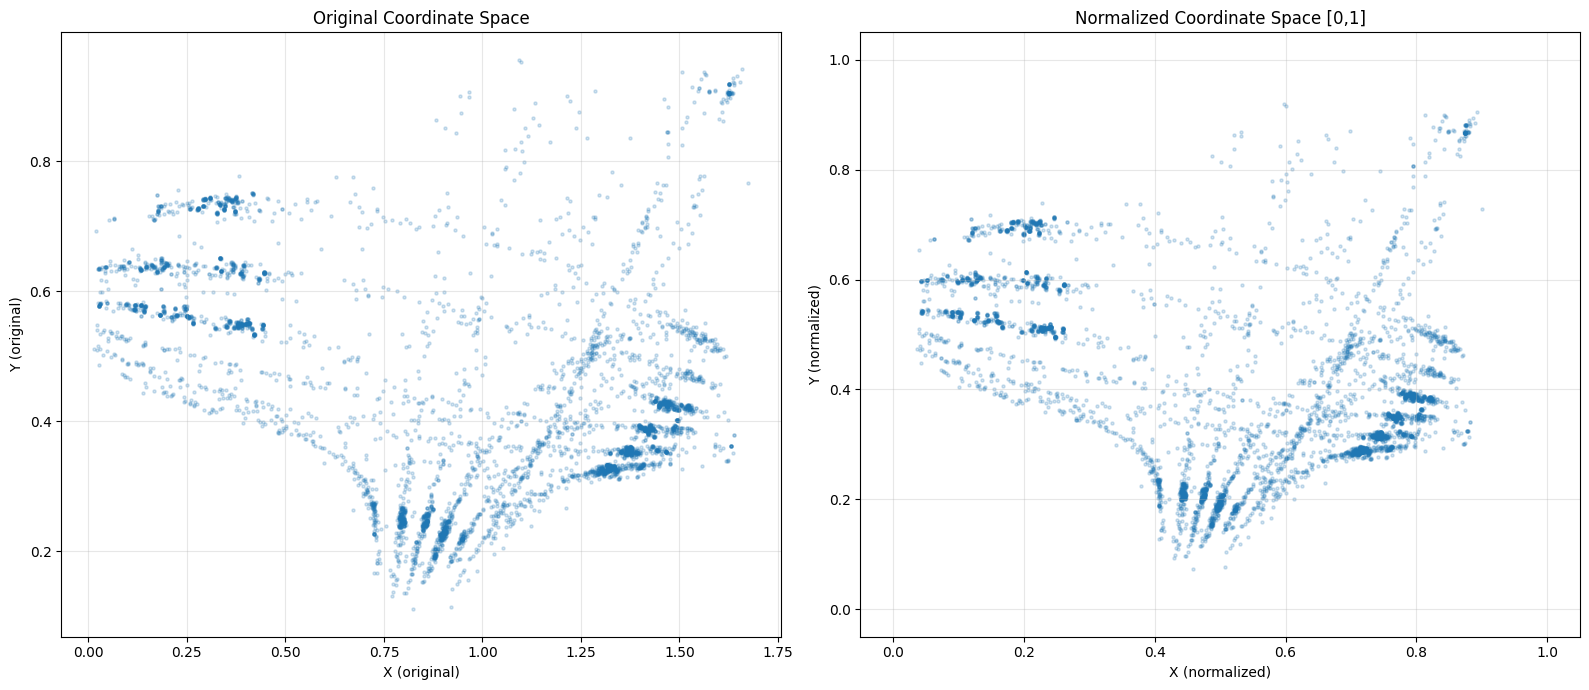


Saved normalization parameters to ../data/processed/bellevue_116th_ne12th/normalization_params.json


In [9]:
import json

# Compute normalization parameters
x_min, x_max = clean_trajectories['x'].min(), clean_trajectories['x'].max()
y_min, y_max = clean_trajectories['y'].min(), clean_trajectories['y'].max()

print("Coordinate ranges:")
print(f"  X: [{x_min:.3f}, {x_max:.3f}] → range = {x_max - x_min:.3f}")
print(f"  Y: [{y_min:.3f}, {y_max:.3f}] → range = {y_max - y_min:.3f}")

# Apply normalization
clean_trajectories['x_norm'] = (clean_trajectories['x'] - x_min) / (x_max - x_min)
clean_trajectories['y_norm'] = (clean_trajectories['y'] - y_min) / (y_max - y_min)

print("\nNormalized ranges:")
print(f"  X_norm: [{clean_trajectories['x_norm'].min():.3f}, {clean_trajectories['x_norm'].max():.3f}]")
print(f"  Y_norm: [{clean_trajectories['y_norm'].min():.3f}, {clean_trajectories['y_norm'].max():.3f}]")

# Visualize normalized space
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Original coordinates
ax = axes[0]
sample = clean_trajectories.sample(min(5000, len(clean_trajectories)))
ax.scatter(sample['x'], sample['y'], alpha=0.2, s=5)
ax.set_xlabel('X (original)')
ax.set_ylabel('Y (original)')
ax.set_title('Original Coordinate Space')
ax.grid(True, alpha=0.3)

# Normalized coordinates
ax = axes[1]
ax.scatter(sample['x_norm'], sample['y_norm'], alpha=0.2, s=5)
ax.set_xlabel('X (normalized)')
ax.set_ylabel('Y (normalized)')
ax.set_title('Normalized Coordinate Space [0,1]')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save normalization parameters
norm_params = {
    'x_min': x_min,
    'x_max': x_max,
    'y_min': y_min,
    'y_max': y_max
}

norm_params_path = processed_dir / "normalization_params.json"
with open(norm_params_path, 'w') as f:
    json.dump(norm_params, f, indent=2)

print(f"\nSaved normalization parameters to {norm_params_path}")

## Summary and Recommendations

Review preprocessing results and suggest next steps.

In [10]:
print("=" * 60)
print("PREPROCESSING SUMMARY")
print("=" * 60)

print("\n1. DATA QUALITY:")
print(f"   - Original tracks: {len(track_metrics)}")
print(f"   - Clean tracks: {len(clean_track_ids)} ({100*len(clean_track_ids)/len(track_metrics):.1f}%)")
print(f"   - Noise removed: {len(noise_track_ids)} ({100*len(noise_track_ids)/len(track_metrics):.1f}%)")

print("\n2. TRACK CHARACTERISTICS (clean data):")
duration_clean = track_metrics[~track_metrics['is_noise']]['duration']
print(f"   - Duration: {duration_clean.min():.0f} to {duration_clean.max():.0f} frames")
print(f"   - Mean duration: {duration_clean.mean():.1f} frames")

print("\n3. SPATIAL EXTENT:")
print(f"   - X range: [{x_min:.3f}, {x_max:.3f}]")
print(f"   - Y range: [{y_min:.3f}, {y_max:.3f}]")

print("\n4. RECOMMENDED OPTICS PARAMETERS:")
n_clean = len(clean_track_ids)
recommended_min_samples = max(10, int(n_clean * 0.02))  # 2% of data
print(f"   - min_samples: {recommended_min_samples} (2% of {n_clean} tracks)")
print("   - xi: 0.03-0.05 (start with 0.03 for more clusters)")
print("   - max_eps: 0.10-0.15 (normalized coordinates)")

print("\n5. NEXT STEPS:")
print("   - Update trajectories.parquet with cleaned data, OR")
print("   - Modify run_cluster.py to load trajectories_cleaned.parquet")
print("   - Run clustering with recommended parameters")
print("   - Expect 8-16 clusters for 4-way intersection")

print("\n" + "=" * 60)

PREPROCESSING SUMMARY

1. DATA QUALITY:
   - Original tracks: 19827
   - Clean tracks: 3050 (15.4%)
   - Noise removed: 16777 (84.6%)

2. TRACK CHARACTERISTICS (clean data):
   - Duration: 10 to 5302 frames
   - Mean duration: 382.8 frames

3. SPATIAL EXTENT:
   - X range: [-0.056, 1.865]
   - Y range: [0.038, 1.037]

4. RECOMMENDED OPTICS PARAMETERS:
   - min_samples: 61 (2% of 3050 tracks)
   - xi: 0.03-0.05 (start with 0.03 for more clusters)
   - max_eps: 0.10-0.15 (normalized coordinates)

5. NEXT STEPS:
   - Update trajectories.parquet with cleaned data, OR
   - Modify run_cluster.py to load trajectories_cleaned.parquet
   - Run clustering with recommended parameters
   - Expect 8-16 clusters for 4-way intersection

